# Team 1: Characterizing the spatiotemporal changes of wildland-urban interface in the United States

## Background

The wildland-urban interface (WUI) indicates the interface areas between the urban environment and wilderness. WUI areas come with a large risk of wildfire, and with the increased migration and associated development, these WUI areas gain more fuel for wildfires to burn more intensely. The purpose of the project is to map WUI areas in the United States using current definitions and to apply the mapped WUI areas to characterize spatiotemporal changes by taking advantage of the advances in HPC, cyberGIS, machine learning, and/or big data. Examples of such changes could include the geographic extent of WUI areas, spatiotemporal trends of demographic factors, changes in wildfire activities over recent decades, and/or changes to vegetation and climate drivers of wildfire in WUI areas.

## Motivation

Interactions between humans and nature has resulted in ongoing conflicts and considerations for the proper management of socio-ecological systems. On such conflict is the continual urbanization of land within the United States has led to increasing human encroachment into natural wildlands. The presence of WUIs has important implications for wildfire management, as these areas are at high risk of wildfires due to the large extent of flammable material and human activity (Li et al., 2022). Most wildfire disasters occur at the WUI

## Mapping and analyzing the Wildland Urban Interface through time

While the National Land Cover Database is available at 2-3 year intervals since 2000, the Microsoft Building Footprints are produced for a single point in time using modern imagery. To assess change in the Wildland Urban Interface as a timeseries, the team applied a novel approach to create a pseudo timeseries of building footprints.

For each NLCD timestep, the Microsoft Buildings were masked if they were not included in NLCD developed classes. In general, there is strong correspondence between NLCD developed classes and building footprints in the contemporary datasets, lending confidence to using this methodology to produce the pseudo-timeseries. Future validation will be completed to further assess the appropriateness of this approach.

## Methodology Overview

**WUI Definitions:**
Wildland Urban-Interface (WUI) Community exists where structures directly abut wildland fuels and the Intermix Community exists where structures are scattered throughout a wildland area.

**WUI Criteria:**
WUI area should meet requirements of a) intermix: high-density houses surrounded by high-density wildland vegetation (50% of vegetation area) or b) interface: high-density houses adjacent to, that is within 1.5 miles (2.4 km) of a large tract of contiguous wildland vegetation (75% of vegetation area).
High-density housing is ≥ 1 house/40 acres (6.17 houses/km2 or 1 house/400m resolution grid cell).

![Image Description](https://drive.google.com/uc?export=view&id=1t29wj0amfm_z_uFEeuiIxamHSzzY8gw8)

For the purposes of our week-long project, we were only able to map the WUI intermix. Mapping the WUI on Google Earth Engine is very computationally intensive, particularly because vegetation is being mapped at a 30m by 30m resolution. Mapping the WUI interface will be postponed for further research.

## Import libraries and authenticate to Earth Engine

In [ ]:
# Must have Earth Engine account to authenticate
import ee

In [ ]:
ee.Authenticate()
ee.Initialize(project='rohan-wui-iguide')#Change project name as required

In [ ]:
!pip install -q geoplot
!pip install -q pysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 7.0 MB/s eta

In [ ]:
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import Layout
from ipywidgets import interact
import geemap
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
import mapclassify as mc
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import pysal as ps
import libpysal
from splot.esda import plot_moran_bv
from shapely.geometry import MultiPolygon
import json

## Mapping the Wildland Urban Interface

### Study Area

This code snippet defines the study area for WUI mapping.

In [ ]:
states_fc = ee.FeatureCollection("TIGER/2018/States")
usa_feature_collection = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
usa = usa_feature_collection.filter(ee.Filter.eq('country_na', 'United States'))
conusStates = states_fc.filter(ee.Filter.inList('STUSPS', ['AK', 'HI']).Not())
conusGeometry = conusStates.geometry()

#USER INPUT NEEDED
Geometry = usa.geometry()

### Wildland Urban Intermix

The **Intermix WUI** are areas with more than 6.17 buildings per km2 (or **one building per 40 acres**) and **a wildland vegetation area share of greater than or equal to 50%.**

#### Vegetation Layer

The code performs geospatial analysis on land cover data from the National Land Cover Database (NLCD) for the years. The available years are **2011, 2013, 2016, 2019**. This section takes the user input for the interested year.

In [ ]:
text = widgets.Text(
    value='',
    placeholder='Type the year here',
    description='Year:',
    disabled=False
)

global user_year
user_year = None

display(text)

def handle_text(sender):
    global user_year
    user_year = text.value
    print(f'Using NLCD data for the year {user_year}.')

text.on_submit(handle_text)

Text(value='', description='Year:', placeholder='Type the year here')

Using NLCD data for the year 2019.


So, it imports the NLCD image and extracts its projection for future re-projection tasks. The `landcover` band from this NLCD image is then remapped to create a binary image (`veg_i`) representing "natural" vegetation. Specifically, it sets land use codes—**41 (Deciduous Forest), 42 (Evergreen Forest), 43 (Mixed Forest), 52 (Shrubland), and 71 (Grassland)—to 1**, while all other land cover types are set to 0.

In [ ]:
nlcd_i = ee.Image(f'USGS/NLCD_RELEASES/2019_REL/NLCD/{user_year}')
projection = nlcd_i.projection()
scale = projection.nominalScale()
veg_i = nlcd_i.select('landcover').remap([41,42,43,52,71],[1, 1, 1, 1, 1],0)

#### Moving Area Kernel

Subsequently, a circular kernel with a **radius of 226.195 meters** is defined for a **moving window analysis (same area as the square with side of 400.92 meters)**. The mean value of each neighborhood, defined by this kernel, is computed on the binary vegetation image. This newly generated image (`countCir`) is then reprojected to match the original NLCD image's projection. Finally, a threshold is applied to `countCir` to produce a binary image (`threshold50abv`) where **areas with at least 50% "natural" vegetation within the specified kernel are highlighted**.

In [ ]:
# Defined kernel based on WUI definition and perform moving window (reduceNeighborhood)
kernel = ee.Kernel.circle(226.195, 'meters')
countCir = veg_i.reduceNeighborhood(reducer=ee.Reducer.mean(), kernel=kernel).reproject(crs=projection)
threshold50abv = countCir.gte(0.5)

#### Building Layer

The National Land Cover Database (NLCD) image is remapped to create a binary image (`dev_i`) representing developed areas, the same way as we did the vegetation. The land use codes **21 (Developed, Open Space), 22 (Developed, Low Intensity), 23 (Developed, Medium Intensity), and 24 (Developed, High Intensity)** are remapped to the value of 1. All other land cover types that are not in the list are set to 0.

In [ ]:
dev_i = nlcd_i.select('landcover').remap([21,22,23,24],[1, 1, 1, 1],0)

A function `get_state_image()` is defined to **convert Microsoft Buildings State Feature Collections to raster images**, reprojecting them to match the NLCD's resolution. The function **sets a property "build" with a value of 1** for each feature in the collection, and then reduces these features to an image using the **sum reducer**.

In [ ]:
def get_state_image(path):
    fc = ee.FeatureCollection(path)
    new_fc = fc.map(lambda feature: feature.set("build", 1))
    image_fc = new_fc.reduceToImage(
        properties=['build'],
        reducer=ee.Reducer.sum()
    ).reproject(
        crs=projection,
        scale=scale
    ).gt(0)
    return image_fc

The `run_state()` function performs a **moving window analysis using a circular kernel with a radius of 226.195 meters** on each state. It multiplies the developed areas (`dev_i`) with the state-specific building image (`st_image_fc`) to generate a new image (`year_building`). The function then **calculates the mean building density in each neighborhood** and produces a binary image (`dense_houses`).

In [ ]:
def run_state(folder):
    path = folder["id"]
    st_name = path[45:]
    state_f = ee.Feature(states_fc.filter(ee.Filter.eq('NAME', st_name)).first())
    st_image_fc = get_state_image(path)
    year_building = dev_i.multiply(st_image_fc)
    kernel = ee.Kernel.circle(226.195, 'meters')
    house_den = year_building.reduceNeighborhood(
        reducer=ee.Reducer.mean(),
        kernel=kernel,
    ).reproject(
        crs=projection,
    )
    dense_houses = house_den.gt(0)
    return dense_houses

Finally, the code lists all assets in a specified open dataset containing **Microsoft Buildings data**, iterates over each state, and runs the `run_state()` function. The resulting images are then collected into an Image Collection and **reduced using the max reducer** to produce a **final 30-meter resolution binary image** (`buildings`) that **satisfies the Wildland-Urban Interface (WUI) building density definition** for each CONUS state.

>  **High-density housing = 1 house per 160000 sq.mtrs**



In [ ]:
# Run functions above to generate Image Collection of 30m binary image of pixels that satisfy WUI building density definition for each state
def list_ee_assets(folder):
    return [asset['id'] for asset in ee.data.listAssets({'parent': folder})['assets']]

buildings_dir = list_ee_assets('projects/sat-io/open-datasets/MSBuildings/US')
buildings = []

for i in buildings_dir:
    new_layer = run_state({'id': i})
    buildings.append(new_layer)

buildings = ee.ImageCollection(buildings).reduce(ee.Reducer.max())

#### Generating WUI Intermix

This part transforms and filters the **wuimix** image to represent regions that meet both the **vegetation and building criteria** based on the **threshold50abv and buildings** images.

In [ ]:
# Generate output that satisfies both vegetation and building requirements of WUI definition
wuimix = threshold50abv.multiply(buildings)
mask = wuimix.eq(1)
wuimix = wuimix.updateMask(mask)

#### Export Result to Drive

This part takes in the filename for the map to be saved in the user's Google Drive.

In [ ]:
text = widgets.Text(
    value='',
    placeholder='Type the filename here (Eg: Example: - WUI_Intermix_2019)',
    description='File Name:',
    disabled=False
)

global fileName
fileName = None

display(text)

def handle_text(sender):
    global fileName
    fileName = text.value
    print(f'Storing as {fileName}.')

text.on_submit(handle_text)

**Warning: Very Important: Pre-Run Instructions**

Please carefully read the following instructions before running the next cell:

1.   **Google Drive Folder**: Ensure that you have a folder named GoogleEarthEngine in your connected Google Drive.
2.   **Changing the Folder**: If you wish to use a different folder, you can change the folder parameter in the code.
3.   **Processing Time**: The time it takes to process the data may vary significantly depending on your chosen Study Area.


        Example: Processing WUI Intermix data for the year 2019 for the CONUS (Contiguous United States) took approximately 8 hours.

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=interface_wui,
    description=fileName,# Example: - WUI_Intermix_2019
    folder='GoogleEarthEngine',
    fileNamePrefix=fileName,
    region=Geometry.getInfo()['coordinates'],
    scale=int(scale.getInfo()),
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

task.start()

Example: **WUI Intermix 2019**

![WUIIntermix2019](https://drive.google.com/uc?export=view&id=1zU_3Ms01FrGoR35Ta0xJLLzQ0Jnwcdjo)



---



### Wildland Urban Interface

Interface WUI represents **settled areas that have less than 50% vegetation**, but **lie within 1.5 miles (2.4 km)** of a **densely vegetated area (at least 75% wildland vegetation)** that is at least **5 km2** in size.

#### Lower Vegetation Surroundings

This section is designed to **identify areas with less than 50% vegetation** within a specific neighborhood around each pixel. It operates on an Earth Engine image (veg_i) that likely represents vegetation levels. The reduceNeighborhood() method calculates the mean vegetation level **within a circular neighborhood of radius 226.195 meters** around each pixel. The `.lt(0.5)` method creates a binary image, setting pixels to 1 where the mean vegetation level in the neighborhood is less than 50% (0.5) and 0 otherwise. The resulting image, `threshold50bel`, serves as a mask that highlights areas with less than 50% vegetation within the defined neighborhood.

In [ ]:
# Identify areas with less than 50% vegetation
threshold50bel = veg_i.reduceNeighborhood(
    reducer=ee.Reducer.mean(),
    kernel=ee.Kernel.circle(226.195, 'meters')
).reproject(projection).lt(0.5)

This section performs multiplication to **identify building areas that are surrounded by less than 50% vegetation.** It multiplies two Earth Engine images: `threshold50bel` and `buildings`. The `threshold50bel` image is a binary mask that indicates areas with less than 50% vegetation. The `buildings` image represents the presence of densely distributed buildings.

In [ ]:
# Multiply with the buildings layer to isolate building areas with less than 50% vegetation
less_veg_near_buildings = threshold50bel.multiply(buildings)

#### Dense Vegetation Surroundings

Here it identifies **areas with at least 75% vegetation within a 226.195-meter radius around each pixel**. It uses `reduceNeighborhood()` method on the `veg_i` image to calculate the mean vegetation level in each neighborhood and reprojects the image to a specific projection. The resulting image, `dense_vegetation`, is then thresholded and self-masked to isolate areas where the **mean vegetation level is greater than or equal to 75%**.

In [ ]:
# Identify Densely Vegetated Areas (at least 75% vegetation)
dense_vegetation = veg_i.reduceNeighborhood(
    reducer=ee.Reducer.mean(),
    kernel=ee.Kernel.circle(226.195, 'meters')
).reproject(projection).gte(0.75).selfMask()

It converts the **dense_vegetation image into a vector** format using Earth Engine's `reduceToVectors()` method. It opts for a **four-connected pixel neighborhood**.




> **Please change the statecode based on which state you would like to map. Otherwise it will only work for Rhode Island**



In [ ]:
#Change the statecode based on which state you would like to map
state = states_fc.filter(ee.Filter.eq('STUSPS', 'RI'));
Geometry = state.geometry();
# Convert to vector
vectors = dense_vegetation.reduceToVectors(
    geometry=Geometry,
    geometryType='polygon',
    eightConnected=False,
    maxPixels=1e13
)

#### Large Tracts

The code filters the `vectors` object to **retain polygons with property greater than 5 km<sup>2**, creating `large_tracts`. It then converts these filtered polygons back into an image format using `reduceToImage()`, with the 'label' property determining pixel values. The resulting image is stored in `large_tracts_image`.

In [ ]:
# Filter large tracts
large_tracts = vectors.filter(ee.Filter.gt('count', 5556))
# Convert to image
large_tracts_image = large_tracts.reduceToImage(
    properties=['label'],
    reducer=ee.Reducer.first()
)

#### Buffered Distance

The code multiplies the `dense_vegetation` image with the `large_tracts_image`, generating `finalDenseVegetation` that combines both criteria. Then, **it creates a 2.4 km buffer around these areas** using `focal_max()` with an 80-pixel radius, resulting in `buffered_large_tracts`.

In [ ]:
# Multiply with original dense vegetation image
finalDenseVegetation = dense_vegetation.multiply(large_tracts_image)
# Create a 2.4 km buffer around the finalDenseVegetation areas
buffered_large_tracts = finalDenseVegetation.focal_max(80, 'circle', 'pixels')

#### Generating WUI Interface

The code multiplies `less_veg_near_buildings` with `buffered_large_tracts`, isolating **dense building with less vegetation areas near the buffered high-vegetation tracts**. The result - `interface_wui`, is then self-masked to highlight these regions.

In [ ]:
# Combine these buffered areas with building areas having less than 50% vegetation
interface_wui = less_veg_near_buildings.multiply(buffered_large_tracts).selfMask()

#### Export Result to Drive

This part takes in the filename for the map to be saved in the user's Google Drive.

In [ ]:
text = widgets.Text(
    value='',
    placeholder='Type the filename here (Eg: Example: - WUI_Interface_2019)',
    description='File Name:',
    disabled=False
)

global fileName
fileName = None

display(text)

def handle_text(sender):
    global fileName
    fileName = text.value
    print(f'Storing as {fileName}.')

text.on_submit(handle_text)

**Warning: Very Important: Pre-Run Instructions**

Please carefully read the following instructions before running the next cell:

1.   **Google Drive Folder**: Ensure that you have a folder named GoogleEarthEngine in your connected Google Drive.
2.   **Changing the Folder**: If you wish to use a different folder, you can change the folder parameter in the code.
3.   **Processing Time**: The time it takes to process the data may vary significantly depending on your chosen Study Area.


        Example: Processing WUI Interface data for the year 2019 for the CONUS (Contiguous United States) took approximately 15 days for all the states together.

In [ ]:
task = ee.batch.Export.image.toDrive(
    image=interface_wui,
    description=fileName,# Example: - WUI_Interface_2019
    folder='GoogleEarthEngine',
    fileNamePrefix=fileName,
    region=Geometry.getInfo()['coordinates'],
    scale=int(scale.getInfo()),
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)

task.start()

Example: **WUI Interface 2019**

![WUIInterface2019](https://drive.google.com/uc?export=view&id=1zP36w48kaoBiUD8ay8RLm6PB1QbQR1a4)



## Validation

Example: **WUI 2019**

![WUI2019](https://drive.google.com/uc?export=view&id=1r1ZH0SFRhxI6hvLcFT2p5n-w0h3Syx2W)

For validation purposes, we **overlayed the Rhode Island** result with prevalent sources. The map on the **left** hand side is **from SILVIS lab**. We used this to appraise our results. ***The SILVIS map is based on Block group geometry***. When overlayed, it shows us that our results have **identified WUI areas correctly** in the given polygons **at a much finer scale.**



> **Note**: The polygons on the right side has gotten removed while clipping the datasets to improve computation time through batch processing of the states. Please refer to the right side of the state only.



![RI](https://drive.google.com/uc?export=view&id=1hfIu0cn6q6iPzl-gLan8oKXNWfqr3f5Y)


## Exploratory Data Analysis

In this section, we'll dive into exploratory data analysis. To proceed, please ** upload the WUI** (Wildland-Urban Interface) maps you've generated from the previous code blocks into your **Earth Engine Assets**. Once uploaded, enter the corresponding asset paths in the designated area of the code.

**Note**: If you haven't generated your own WUI maps or prefer to use pre-existing resources, the default paths are set to point to **WUI maps created by the IGUIDE team**.

### Load Generated Maps

In [ ]:
# Default paths
default_values = {
    'WUI_Intermix2019': 'projects/dri-apps/assets/iguide-team1/intermix2019',
    'WUI_Intermix2016': 'projects/dri-apps/assets/iguide-team1/intermix2016',
    'WUI_Intermix2013': 'projects/dri-apps/assets/iguide-team1/intermix',
    'WUI_Intermix2011': 'projects/rohan-wui-iguide/assets/WUI_intermix_2011',#projects/dri-apps/assets/iguide-team1/intermix2011
    'WUI_Interface2019': 'projects/rohan-wui-iguide/assets/WUI_interface_2019',
    'WUI_Interface2016': 'projects/rohan-wui-iguide/assets/WUI_2016_interface_final',
    'WUI_Interface2013': 'projects/rohan-wui-iguide/assets/WUI_interface_2013',
    'WUI_Interface2011': 'projects/rohan-wui-iguide/assets/WUI_interface_2011',
}
print("Enter the EE Assets Path for respective maps:\n")
text_layout = Layout(width= "450px")
description_layout = Layout(width= "300px")
text_widgets = {key: widgets.Text(
                    placeholder=value,
                    description=f'{key}:',
                    disabled=False,
                    layout=text_layout,
                    style={'description_width': 'initial'}
                )
                for key, value in default_values.items()}
global user_values
user_values = {}
def on_submit(sender):

    for key, widget in text_widgets.items():
        user_value = widget.value if widget.value else default_values[key]  # Use default if empty
        user_values[key] = user_value
    print("\nCaptured values:\n")
    for key, value in user_values.items():
        print(f"{key}: {value}")

for widget in text_widgets.values():
    widget.on_submit(on_submit)

for widget in text_widgets.values():
    display(widget)

Enter the EE Assets Path for respective maps:



Text(value='', description='WUI_Intermix2019:', layout=Layout(width='450px'), placeholder='projects/dri-apps/a…

Text(value='', description='WUI_Intermix2016:', layout=Layout(width='450px'), placeholder='projects/dri-apps/a…

Text(value='', description='WUI_Intermix2013:', layout=Layout(width='450px'), placeholder='projects/dri-apps/a…

Text(value='', description='WUI_Intermix2011:', layout=Layout(width='450px'), placeholder='projects/dri-apps/a…

Text(value='', description='WUI_Interface2019:', layout=Layout(width='450px'), placeholder='projects/rohan-wui…

Text(value='', description='WUI_Interface2016:', layout=Layout(width='450px'), placeholder='projects/rohan-wui…

Text(value='', description='WUI_Interface2013:', layout=Layout(width='450px'), placeholder='projects/rohan-wui…

Text(value='', description='WUI_Interface2011:', layout=Layout(width='450px'), placeholder='projects/rohan-wui…


Captured values:

WUI_Intermix2019: projects/dri-apps/assets/iguide-team1/intermix2019
WUI_Intermix2016: projects/dri-apps/assets/iguide-team1/intermix2016
WUI_Intermix2013: projects/dri-apps/assets/iguide-team1/intermix
WUI_Intermix2011: projects/dri-apps/assets/iguide-team1/intermix2011
WUI_Interface2019: projects/rohan-wui-iguide/assets/WUI_interface_2019
WUI_Interface2016: projects/rohan-wui-iguide/assets/WUI_2016_interface_final
WUI_Interface2013: projects/rohan-wui-iguide/assets/WUI_interface_2013
WUI_Interface2011: projects/rohan-wui-iguide/assets/WUI_interface_2011


This code obtains the combined binary layer for each year for **areas having WUI intermix or WUI Interface areas.**

In [ ]:
TotalWUI2011 = ee.ImageCollection(user_values["WUI_Intermix2011"]).mosaic().add(ee.Image(user_values["WUI_Interface2011"])).selfMask()
TotalWUI2013 = ee.ImageCollection(user_values["WUI_Intermix2013"]).mosaic().add(ee.Image(user_values["WUI_Interface2013"])).selfMask()
TotalWUI2016 = ee.ImageCollection(user_values["WUI_Intermix2016"]).mosaic().add(ee.Image(user_values["WUI_Interface2016"])).selfMask()
TotalWUI2019 = ee.ImageCollection(user_values["WUI_Intermix2019"]).mosaic().add(ee.Image(user_values["WUI_Interface2019"])).selfMask()

### Temporal Pattern Year Slider

**Year Slider Example Use**
![picture](https://drive.google.com/uc?export=view&id=1IEGkSaAemGT4SMKvpv7tOh75Q5aP8EHH)

In [ ]:
Map = geemap.Map(center=(40, -100), zoom=4)

intermix_vis = {'min': 0, 'max': 1, 'palette': ['black', '#b10026']}
interface_vis = {'min': 0, 'max': 1, 'palette': ['black', '#fd8d3c'], 'opacity': 0.5}

current_layers = []

def update_map(year):
    global current_layers
    for layer in current_layers:
        Map.remove_ee_layer(name=layer)
    current_layers.clear()
    intermix_layer_name = f"WUI_Intermix{year}"
    interface_layer_name = f"WUI_Interface{year}"
    intermix_img = ee.ImageCollection(user_values[intermix_layer_name]).mosaic().selfMask()
    interface_img = ee.Image(user_values[interface_layer_name]).selfMask()
    Map.add_ee_layer(intermix_img, intermix_vis, intermix_layer_name)
    Map.add_ee_layer(interface_img, interface_vis, interface_layer_name)
    current_layers.append(intermix_layer_name)
    current_layers.append(interface_layer_name)

year_slider = widgets.SelectionSlider(
    options=[2011, 2013, 2016, 2019],
    value=2019,
    description='Year:',
    disabled=False,
    continuous_update=False
)
interact(update_map, year=year_slider)
Map

interactive(children=(SelectionSlider(continuous_update=False, description='Year:', index=3, options=(2011, 20…

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

**Wildland Urban Interface 2019**
![picture](https://drive.google.com/uc?export=view&id=1r1ZH0SFRhxI6hvLcFT2p5n-w0h3Syx2W)


### Cartogram WUI Increase/Decrease

This code calculates the difference (increase/decrease) between the total Wildland-Urban Interface (WUI) areas for two years 2019 and 2011, represented by `TotalWUI2019` and `TotalWUI2011`. Subsequently, a feature collection of U.S. states is loaded from the *`TIGER/2018/States`* dataset, and an empty dictionary `state_results` is initialized. Finally, a geodataframe containing state `geometries` and a list `st_codes` containing U.S. state abbreviations is defined.

In [ ]:
WUI_difference = TotalWUI2019.subtract(TotalWUI2011)
custom_mask = WUI_difference.abs().eq(1)
WUI_difference = WUI_difference.updateMask(custom_mask)
states_fc = ee.FeatureCollection("TIGER/2018/States")
states_features = states_fc.getInfo()['features']
geometries = [shape(feat['geometry']) for feat in states_features]
state_codes = [feat['properties']['STUSPS'] for feat in states_features]
gdf = gpd.GeoDataFrame({'geometry': geometries, 'STUSPS': state_codes})
st_codes = [
    'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]
gdf = gdf[gdf['STUSPS'].isin(st_codes)]

#### Visualizing Pixels of WUI change

**Example Use:**

![Pixel](https://drive.google.com/uc?id=1yuj5gt3SkymgFbdn5IXnriCJ2Av8YVl4)
![View Image](https://drive.google.com/uc?id=1z4M2TW9oyCYj3VcOCq06-S_N_rb_2Pmp)

In [ ]:
Map = geemap.Map(center=(40, -100), zoom=4)
Map.add_basemap('HYBRID')
red_mask = WUI_difference.eq(1)
green_mask = WUI_difference.eq(-1)
red_image = WUI_difference.updateMask(red_mask)
green_image = WUI_difference.updateMask(green_mask)
red_palette = ["#FF0000"]
green_palette = ["#00FF00"]
Map.addLayer(red_image, {'min': 0, 'max': 1, 'palette': red_palette}, 'Increase (Red)')
Map.addLayer(green_image, {'min': 0, 'max': 1, 'palette': green_palette}, 'Decrease (Green)')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

#### GeoDataFrame for Visualization

In this part, we calculate **the total area changes** occuring per state in terms of **WUI increase or decrease** and storing it into `state_results`.

In [ ]:
state_results = {}
for state_code in st_codes:
    state_geom = states_fc.filter(ee.Filter.eq('STUSPS', state_code)).geometry()
    clipped_red = red_image.clip(state_geom)
    clipped_green = green_image.clip(state_geom)
    increase = clipped_red.reduceRegion(ee.Reducer.count(), geometry=state_geom, scale=30, maxPixels=1e13).getInfo()
    decrease = clipped_green.reduceRegion(ee.Reducer.count(), geometry=state_geom, scale=30, maxPixels=1e13).getInfo()
    total_WUI_area = TotalWUI2019.clip(state_geom).reduceRegion(ee.Reducer.count(), geometry=state_geom, scale=30, maxPixels=1e13).getInfo()

    #print(f"State: {state_code}")
    #print("Increase:", increase)
    #print("Decrease:", decrease)
    #print("Total WUI Area:", total_WUI_area)
    state_results[state_code] = {
        'increase': increase.get('b1', 0) * 900,
        'decrease': decrease.get('b1', 0) * 900,
        'total_WUI_area': total_WUI_area.get('b1', 0) * 900
    }
    #print("Results:", state_results[state_code])

    #Download this in an excel file if you wish to keep a record. The values will be in the unit of square meters

This code snippet populates a `Geodataframe` named **gdf** to store all the details for visualizing. Furthermore, as **Cartograms** cannot work with `GeometryCollection` but only `MultiPolygon` and `Polygon`, so each feature is **iterated to keep only the Polygon features.**

In [ ]:
# Add the WUI area data to the GeoDataFrame
gdf['total_WUI_area'] = gdf['STUSPS'].map(lambda x: state_results.get(x, {}).get('total_WUI_area', 0))
gdf['increase'] = gdf['STUSPS'].map(lambda x: state_results.get(x, {}).get('increase', 0))
gdf['decrease'] = gdf['STUSPS'].map(lambda x: state_results.get(x, {}).get('decrease', 0))

In [ ]:
def convert_geometry(geometry):
    if geometry.geom_type == 'GeometryCollection':
        polygon_parts = [part for part in geometry.geoms if part.geom_type == 'Polygon']
        return MultiPolygon(polygon_parts)
    else:
        return geometry
gdf['geometry'] = gdf['geometry'].apply(convert_geometry)

#### Cartogram

##### WUI Increase

**Example WUI Cartogram 2011-2019**

![CartogramIncrease](https://drive.google.com/uc?id=1ygS1pAP69A2BdUjsdICUFQbdhV5sNWo7)

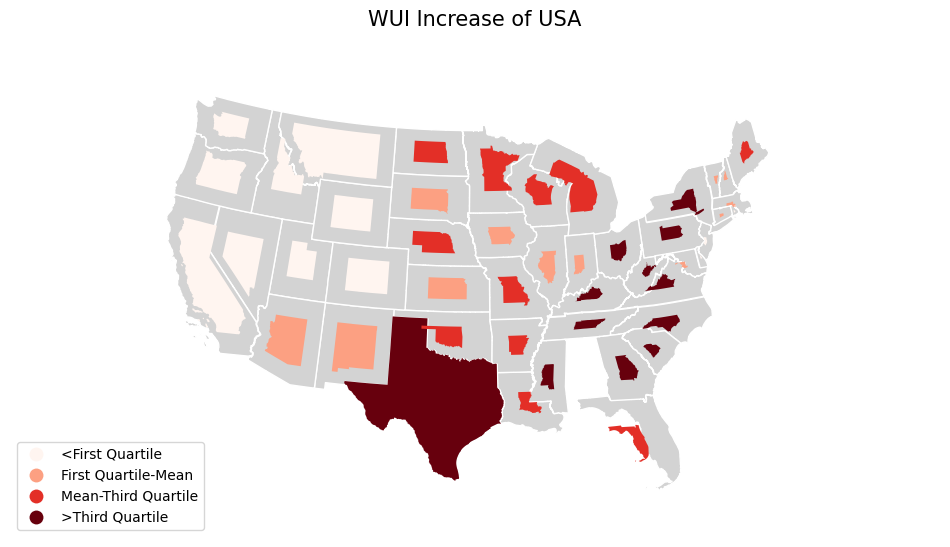

In [ ]:
scheme = mc.Quantiles(gdf['increase'], k=4)
ax1 = gplt.cartogram(
    gdf,
    scale='total_WUI_area',
    hue='increase',
    cmap='Reds',
    legend=True,
    projection=gcrs.AlbersEqualArea(),
    figsize=(12, 12),
    #limits=(0, 1),
    legend_kwargs={'loc': 'lower left'},
    legend_var='hue',
    legend_labels=[
        '<First Quartile', 'First Quartile-Mean', 'Mean-Third Quartile',
        '>Third Quartile'
    ],
    scheme=scheme,
)

gplt.polyplot(gdf, facecolor='lightgrey', edgecolor='white', ax=ax1)
ax1.set_title("WUI Increase of USA", fontdict={"fontsize": 15})
plt.show()

##### WUI Decrease

**Example WUI Cartogram 2011-2019**

![WUI Decrease](https://drive.google.com/uc?id=1yqWzsm_NUb4ugQLmBWf-0fPkUDRYfhfU)

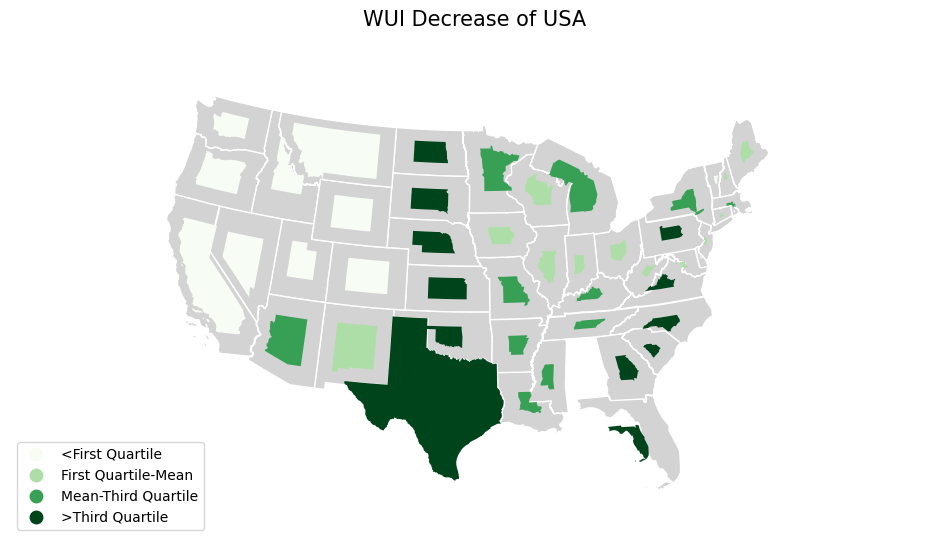

In [ ]:
scheme = mc.Quantiles(gdf['decrease'], k=4)
ax1 = gplt.cartogram(
    gdf,
    scale='total_WUI_area',
    hue='decrease',
    cmap='Greens',
    legend=True,
    projection=gcrs.AlbersEqualArea(),
    figsize=(12, 12),
    #limits=(0, 1),
    legend_kwargs={'loc': 'lower left'},
    legend_var='hue',
    legend_labels=[
        '<First Quartile', 'First Quartile-Mean', 'Mean-Third Quartile',
        '>Third Quartile'
    ],
    scheme=scheme,
)

gplt.polyplot(gdf, facecolor='lightgrey', edgecolor='white', ax=ax1)
ax1.set_title("WUI Decrease of USA", fontdict={"fontsize": 15})
plt.show()

## Analysing Social and Structural Vulnerability

Analysis of the **Social Vulnerability Index (NASA SEDAC) and Wildfire Risk** to Communities **Risk to Potential Structures (US Forest Service, LANDFIRE)** for the **Wildland Urban Interface**. The `Social Vulnerability Index` was downloaded from https://sedac.ciesin.columbia.edu/data/set/usgrid-us-social-vulnerability-index and the `LANDFIRE` data was already an Earth Engine asset.

### Visualization

**Example Use: Indexes in the WUI Area**

<img src="https://drive.google.com/uc?id=1z5HWGBZTddx0Q0ZpghzlV0aD7qLA-x1Q" alt="SoVI" height="200"> <img src="https://drive.google.com/uc?id=1zA9Xz3nRpjVSSs8woXzw0FYcqwNsCvCR" alt="Risk" height="200">


In [ ]:
Map = geemap.Map(center=[40, -100], zoom=4)

# Risk to Potential Structures for 2014
hpb = ee.ImageCollection('projects/climate-engine-pro/assets/ce-wrc-static').select('RPS').mosaic()
hpb_c = ["#ffffb2", "#fed976", "#feb24c", "#fd8d3c", "#fc4e2a", "#e31a1c", "#b10026"]
Map.addLayer(hpb, {'min':0, 'max':1, 'palette': hpb_c},'Risk',False)
# Social Vulnerability Index for 2014
svi = ee.Image('projects/dri-apps/assets/iguide-team1/svi_2014')
svi_c = ["#edf8fb", "#bfd3e6", "#9ebcda", "#8c96c6", "#8c6bb1", "#88419d", "#6e016b"]
Map.addLayer(svi, {'min':0, 'max':1, 'palette': svi_c},'Vulnerability',False)
# WUI image for 2013
#intermix = ee.ImageCollection('projects/dri-apps/assets/iguide-team1/intermix').mosaic().selfMask()
intermix= TotalWUI2013.selfMask()

# Masking by WUI
svi_mask = svi.updateMask(intermix)
hpb_mask = hpb.updateMask(intermix)

# Visualization parameters
hpb_params = {'min': 0, 'max': 1, 'palette': ['#ffffb2', '#b10026']}
svi_params = {'min': 0, 'max': 1, 'palette': ['#edf8fb', '#6e016b']}
intermix_params = {'min': 0, 'max': 1, 'palette': ['#D8B365', '#5AB4AC']}

# Add layers to the map
Map.addLayer(intermix, intermix_params, 'WUI')
Map.addLayer(svi_mask, svi_params, 'Vulnerability WUI')
Map.addLayer(hpb_mask, hpb_params, 'Risk WUI')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(ch…

### Bivariate Moran's I

This code is to convert the masked risk and vulnerability values to geodatabase for Moran's I computations

In [ ]:
counties = ee.FeatureCollection("TIGER/2016/Counties")
# CONUS states
conus_fips_codes = [str(i).zfill(2) for i in range(1, 57) if i not in [2, 15]]
#Prepping GdB
conus_counties = counties.filter(ee.Filter.inList('STATEFP', conus_fips_codes))
counties_features = conus_counties.getInfo()['features']
geometries = [shape(feat['geometry']) for feat in counties_features]
county_ids = [feat['properties']['GEOID'] for feat in counties_features]

Initiating a **dictionary and json file** to store reducer computations to bypass memory limits.

In [ ]:
county_ids.sort()
# Upload existing county_results if available
try:
    with open('county_results.json', 'r') as f:
        county_results = json.load(f)
except FileNotFoundError:
    print("Creating new file")
    county_results = {}

In every county, this code obtains **the mean of the risk and social vulnerability for the pixels which are present in the WUI**.
> Please make sure to download the json file periodically to avoid any lose of data

In [ ]:
for county_id in county_ids:
    if county_id not in county_results:
        county_geom = counties.filter(ee.Filter.eq('GEOID', county_id)).geometry()

        clipped_hpb = hpb_mask.clip(county_geom)
        clipped_svi = svi_mask.clip(county_geom)
        try:
          hpb_mean = clipped_hpb.reduceRegion(ee.Reducer.mean(), geometry=county_geom, scale=30, maxPixels=1e13).getInfo()
          svi_mean = clipped_svi.reduceRegion(ee.Reducer.mean(), geometry=county_geom, scale=30, maxPixels=1e13).getInfo()

          county_results[county_id] = {
              'hpb_mean': hpb_mean.get('RPS', None),
              'svi_mean': svi_mean.get('b1', None)
          }
          #print(county_id, county_results[county_id])
          if len(county_results) % 10 == 0:
              with open('county_results.json', 'w') as f:
                  json.dump(county_results, f)

        except Exception as e:
            print(f"An error occurred for county_id {county_id}: {e}")

Storing the final results in the json file.

In [ ]:
with open('county_results.json', 'w') as f:
    json.dump(county_results, f)

Merging the data into the GeoDataframe

In [ ]:
gdf = gpd.GeoDataFrame({'geometry': geometries, 'GEOID': county_ids})
gdf['hpb_mean'] = gdf['GEOID'].map(lambda x: county_results.get(x, {}).get('hpb_mean', None))
gdf['svi_mean'] = gdf['GEOID'].map(lambda x: county_results.get(x, {}).get('svi_mean', None))

Removing the GeometryCollections to keep only Polygons

In [ ]:
def convert_geometry(geometry):
    if geometry.geom_type == 'GeometryCollection':
        polygon_parts = [part for part in geometry.geoms if part.geom_type == 'Polygon']
        return MultiPolygon(polygon_parts)
    else:
        return geometry
gdf['geometry'] = gdf['geometry'].apply(convert_geometry)
gdf = gdf.dropna(subset=['svi_mean', 'hpb_mean'])

Final Distribution and Inference:

Bivariate Moran's I: 0.05624913934231314
p-value: 0.001
Positive spatial autocorrelation between SVI Mean and HPB Mean


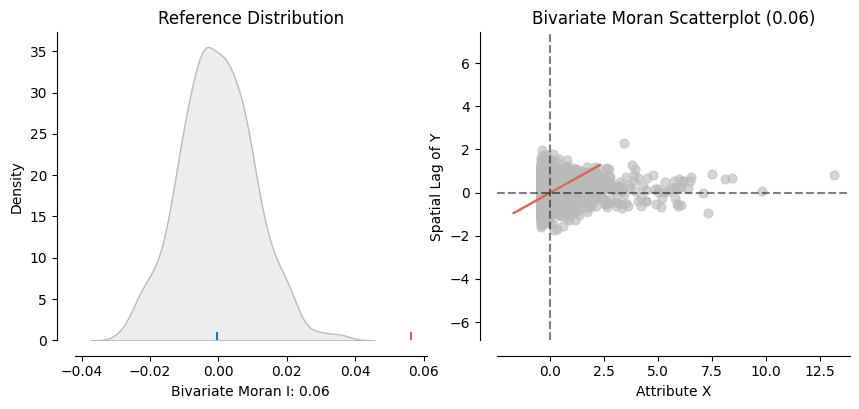

In [ ]:
w = libpysal.weights.Queen.from_dataframe(gdf)
w.transform = 'r'
svi_mean = gdf['svi_mean'].values
hpb_mean = gdf['hpb_mean'].values
moran = ps.explore.esda.moran.Moran_BV(y=svi_mean, x=hpb_mean, w=w)
print(f"Bivariate Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")
if moran.p_sim < 0.05:
    if moran.I > 0:
        print("Positive spatial autocorrelation between SVI Mean and HPB Mean")
    else:
        print("Negative spatial autocorrelation between SVI Mean and HPB Mean")
else:
    print("No significant spatial autocorrelation between SVI Mean and HPB Mean")
plot_moran_bv(moran)
plt.show()

**Result of Moran's I:**

<img src="https://drive.google.com/uc?id=1zDG70PFXDcriX64LXKVriNiytn31iyI9" alt="MoranI" >


## Ethics

### Data Science Ethics Checklist

[![Deon badge](https://img.shields.io/badge/ethics%20checklist-deon-brightgreen.svg?style=popout-square)](http://deon.drivendata.org/)

#### Database Limitations
 - [ ] **Social Vulnerability Index (SVI)**
 >*SVI is a relative score for a locality based upon other localities, so if you're looking at changes over time, changes in vulnerability in a locality may not actually reflect changes within that locality. Additionally, the SVI is based upon Census data, which has its own limitations, such as uncertainty in American Community Survey estimates.*
 - [ ] **National Land Cover Database (NLCD)**
 >*The NLCD has a documented accuracy of 82.0%. In one research paper, scientists found the NLCD significantly underestimates tree cover with a national average underestimation of 9.7% and a max underestimation of 28.4%.*
 - [ ] **Microsoft Building Footprint**
 >*The database is said to be 99.3% precise and have 93.5% recall as matching building metrics.Researchers report the algorithm fails to detect small buildings, that attached buildings with similar heights are consolidated to form single polygons, and that overcounting is an issue in some places.*

#### A. Data Collection
 - [ ] **A.1 Informed consent**: If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?
 >*No, people taking the Census don’t necessarily give informed consent to have their data shared/published, or used for research purposes. On the MIcrosoft Building blueprints side, people do not opt-in to having their house or building included in the dataset.*
 - [ ] **A.2 Collection bias**: Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?
 >*The Social Vulnerability Index (SVI) we are using takes into account 15 different variables at the census tract level, including race. The way the Census accounts for race is not holistic enough, and leaves a lot to be desired. Some of the descriptors for the variables in the index are self-explanatory, but others are not. For example, income and minority are listed as variables, but there’s no further information on exactly what these variables mean.*
 - [ ] **A.3 Limit PII exposure**: Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?
 >*Census data in the SVI is anonymous in and of itself, so this isn’t an issue we need to worry about. We aren’t attaching identifiers to any of the data we’re using, and we’re only putting in the data necessary to answer our research question.*
 - [ ] **A.4 Downstream bias mitigation**: Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?
 >*Using Census/ACS data is difficult because only a small subset of the population is sampled. How random are those samples? Are areas of all races/socioeconomic classes being evaluated? There is also missing data for a bunch of tracts because the ACS only samples certain areas. Therefore, downstream results could lead to a biased outcome if certain racial or income groups are over- or underrepresented in the SVI.*

#### B. Data Storage
 - [ ] **B.1 Data security**: Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?
 >*No, all our data is already publicly available, so we have no further plans to protect and secure our data.*
 - [ ] **B.2 Right to be forgotten**: Do we have a mechanism through which an individual can request their personal information be removed?
 >*Once you have filled out the Census, you have no way of removing your information. Therefore, there is no mechanism by which a person can be removed from the dataset; however, individuals cannot be tied to the dataset due to anonymity, so we don’t foresee this being an issue.*
 - [ ] **B.3 Data retention plan**: Is there a schedule or plan to delete the data after it is no longer needed?
 >*There are no plans for any data (which is publicly available and historical) to ever be deleted or removed, for any of the databases we’re using.*

#### C. Analysis
 - [ ] **C.1 Missing perspectives**: Have we sought to address blindspots in the analysis through engagement with relevant stakeholders (e.g., checking assumptions and discussing implications with affected communities and subject matter experts)?
 >*We recognize that the data we are using could have some issues/blindspots. The Land Use/Vegetation dataset, for example, often significantly underestimates tree cover in areas across the US. Microsoft’s Building Footprint is AI-based mapping, and some building counts are often off due to mishaps in the algorithm.*
 - [ ] **C.2 Dataset bias**: Have we examined the data for possible sources of bias and taken steps to mitigate or address these biases (e.g., stereotype perpetuation, confirmation bias, imbalanced classes, or omitted confounding variables)?
 >*We recognize there is a margin of error associated with ACS data used in the SVI, but there isn’t really a way to mitigate those errors; however, the SVI has a methodology for dealing with margin of errors and missing values in ACS data. It is also recognized as a limitation of the dataset.*
 - [ ] **C.3 Honest representation**: Are our visualizations, summary statistics, and reports designed to honestly represent the underlying data?
 >*We plan to use our visualizations and reports to accurately represent our findings. Map color will be based on intuition (with darker colors and/or reds corresponding to more affected areas) and legends will be prominent enough that the message will be straightforward.*
 - [ ] **C.4 Privacy in analysis**: Have we ensured that data with PII are not used or displayed unless necessary for the analysis?
 >*We have no PII in our datasets.*
 - [ ] **C.5 Auditability**: Is the process of generating the analysis well documented and reproducible if we discover issues in the future?
 >*We will produce a Python notebook with detailed information on how our analysis was conducted. If issues arise in the future, we will be able to return to this notebook to confirm why certain decisions were made. Instructions will be explicitly stated within the code.*

#### D. Modeling
 - [ ] **D.1 Proxy discrimination**: Have we ensured that the model does not rely on variables or proxies for variables that are unfairly discriminatory?
 >*Possibly. Because of how the social vulnerability index is calculated, it seems like areas of high minorities and low income communities could be overrepresented in vulnerable areas. This will be noted as a limitation of using the SVI when we’re drawing up conclusions.*
 - [ ] **D.5 Communicate bias**: Have we communicated the shortcomings, limitations, and biases of the model to relevant stakeholders in ways that can be generally understood?
 >*We understand the shortcomings and limitations of the databases we are using, and have communicated those through our notebook.*

#### E. Deployment
 - [ ] **E.2 Redress**: Have we discussed with our organization a plan for response if users are harmed by the results (e.g., how does the data science team evaluate these cases and update analysis and models to prevent future harm)?
 >*We have not made a plan for potential harm yet, but that is a future conversation we plan on having.*
 - [ ] **E.4 Unintended use**: Have we taken steps to identify and prevent unintended uses and abuse of the model and do we have a plan to monitor these once the model is deployed?
 >*We have identified some potential unintentional uses, such as insurance companies using WUI classifications to raise prices for customers in those areas. WUI data (including exact/known WUI areas) will only be distributed if requested so we'll know where exactly it's going to.*

#### F. Additional/Miscellaneous Categories
 - [ ] **F.1 Database Years**: Does all the data come from the same year?
 >*Due to availability, there are some mismatches between the years of our databases. For example, for the 2014 fire data, we have to use the WUI from 2013. However, we don't forsee many changes occurring from year to year within the WUI and don't believe this will be a huge issue.*
 - [ ] **F.2 Mapping Limitations**: What limitations did we run into while mapping the WUI?
 >*We only mapped the WUI intermix (buildings surrounded by vegetation) did not map the WUI interface (buildings adjacent to wildland areas). Therefore, some of the towns that have been most affected by wildfire damage aren't included in our WUI*

*Data Science Ethics Checklist generated with [deon](http://deon.drivendata.org).*